In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import os
from PIL import Image
from tqdm import tqdm
import glob

In [2]:
# V2
import torch
import torch.nn as nn
import torch.nn.functional as F

class AODnet_MultiBranch(nn.Module):
    def __init__(self):
        super(AODnet_MultiBranch, self).__init__()
        print("[Model] Multi-Branch AODNet 초기화 중...")

        # ----- K1 Branch (작은 스케일 특징 담당) -----
        self.k1_conv1 = nn.Conv2d(3, 3, kernel_size=1)
        self.k1_conv2 = nn.Conv2d(3, 3, kernel_size=3, padding=1)
        self.k1_conv3 = nn.Conv2d(6, 3, kernel_size=5, padding=2)

        # ----- K2 Branch (중간 스케일 특징 담당) -----
        self.k2_conv1 = nn.Conv2d(3, 3, kernel_size=3, padding=1)
        self.k2_conv2 = nn.Conv2d(3, 3, kernel_size=5, padding=2)
        self.k2_conv3 = nn.Conv2d(6, 3, kernel_size=7, padding=3)
        
        # ----- K3 Branch (큰 스케일 특징 담당) -----
        self.k3_conv1 = nn.Conv2d(3, 3, kernel_size=5, padding=2)
        self.k3_conv2 = nn.Conv2d(3, 3, kernel_size=7, padding=3)
        self.k3_conv3 = nn.Conv2d(6, 3, kernel_size=9, padding=4)

        # ----- 3개 브랜치의 결과를 융합(Fusion)하는 레이어 -----
        # 각 브랜치에서 3채널 결과가 나오므로 총 9채널을 입력받아 최종 3채널 k로 만듦
        self.fusion_conv = nn.Conv2d(9, 3, kernel_size=3, padding=1)
        
        self.b = 1 # 대기 산란 모델의 상수

        print("[Model] Multi-Branch AODNet 초기화 완료\n")


    def forward(self, x):
        # --- K1 Branch 연산 ---
        x1_1 = F.relu(self.k1_conv1(x))
        x1_2 = F.relu(self.k1_conv2(x1_1))
        k1_cat = torch.cat((x1_1, x1_2), dim=1)
        k1 = F.relu(self.k1_conv3(k1_cat)) # K1 결과

        # --- K2 Branch 연산 ---
        x2_1 = F.relu(self.k2_conv1(x))
        x2_2 = F.relu(self.k2_conv2(x2_1))
        k2_cat = torch.cat((x2_1, x2_2), dim=1)
        k2 = F.relu(self.k2_conv3(k2_cat)) # K2 결과

        # --- K3 Branch 연산 ---
        x3_1 = F.relu(self.k3_conv1(x))
        x3_2 = F.relu(self.k3_conv2(x3_1))
        k3_cat = torch.cat((x3_1, x3_2), dim=1)
        k3 = F.relu(self.k3_conv3(k3_cat)) # K3 결과

        # --- Fusion 단계 ---
        k_fused = torch.cat((k1, k2, k3), dim=1)
        k_final = F.relu(self.fusion_conv(k_fused)) # 최종 K

        # --- AOD-Net 복원 공식 적용 ---
        output = k_final * x - k_final + self.b
        return F.relu(output)



In [6]:
def print_model_summary(model, model_name):
    """모델의 파라미터 정보와 총 개수를 출력하는 함수"""
    print(f"========== {model_name} Summary ==========")
    
    # 모델의 각 파라미터 이름과 크기(shape) 출력
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"Layer: {name},  Shape: {param.shape}")
    
    # 전체 파라미터 개수 계산 및 출력
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nTotal trainable parameters: {total_params:,}")
    print("=" * (len(model_name) + 24))
    print("\n")


# 1. AODnet 모델 객체 생성 및 파라미터 확인
model = AODnet_MultiBranch()
print_model_summary(model, "AODnet")

[Model] Multi-Branch AODNet 초기화 중...
[Model] Multi-Branch AODNet 초기화 완료

========== AODnet Summary ==========
Layer: k1_conv1.weight,  Shape: torch.Size([3, 3, 1, 1])
Layer: k1_conv1.bias,  Shape: torch.Size([3])
Layer: k1_conv2.weight,  Shape: torch.Size([3, 3, 3, 3])
Layer: k1_conv2.bias,  Shape: torch.Size([3])
Layer: k1_conv3.weight,  Shape: torch.Size([3, 6, 5, 5])
Layer: k1_conv3.bias,  Shape: torch.Size([3])
Layer: k2_conv1.weight,  Shape: torch.Size([3, 3, 3, 3])
Layer: k2_conv1.bias,  Shape: torch.Size([3])
Layer: k2_conv2.weight,  Shape: torch.Size([3, 3, 5, 5])
Layer: k2_conv2.bias,  Shape: torch.Size([3])
Layer: k2_conv3.weight,  Shape: torch.Size([3, 6, 7, 7])
Layer: k2_conv3.bias,  Shape: torch.Size([3])
Layer: k3_conv1.weight,  Shape: torch.Size([3, 3, 5, 5])
Layer: k3_conv1.bias,  Shape: torch.Size([3])
Layer: k3_conv2.weight,  Shape: torch.Size([3, 3, 7, 7])
Layer: k3_conv2.bias,  Shape: torch.Size([3])
Layer: k3_conv3.weight,  Shape: torch.Size([3, 6, 9, 9])
Layer: k3

In [7]:
class DehazeDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        """
        :param data_dir: train, test, val 폴더 중 하나의 경로 (예: 'dataset2_split/train')
        :param transform: 이미지에 적용할 torchvision.transforms
        """
        self.gt_dir = os.path.join(data_dir, 'gt')
        self.input_dir = os.path.join(data_dir, 'input')
        self.transform = transform
        
        # input 폴더의 파일 목록을 기준으로 삼음
        self.image_files = os.listdir(self.input_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        filename = self.image_files[idx]
        
        input_path = os.path.join(self.input_dir, filename)
        gt_path = os.path.join(self.gt_dir, filename)
        
        # PIL 라이브러리를 사용해 이미지 열기 (RGB 형식으로 변환)
        input_image = Image.open(input_path).convert('RGB')
        gt_image = Image.open(gt_path).convert('RGB')
        
        if self.transform:
            input_image = self.transform(input_image)
            gt_image = self.transform(gt_image)
            
        return input_image, gt_image

In [8]:
# GPU 사용 설정
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# 하이퍼파라미터
LEARNING_RATE = 0.0001
BATCH_SIZE = 16
NUM_EPOCHS = 100

# 데이터셋 경로 (split_dataset.py 실행 후 생성된 폴더)
DATA_DIR = "./dataset_split"
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VAL_DIR = os.path.join(DATA_DIR, 'val')

# 학습된 모델 가중치를 저장할 경로
MODEL_SAVE_PATH = "./pt/TBaodNet"
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

Using device: cuda


In [9]:
# 이미지 변환 설정
transform = transforms.Compose([
    transforms.Resize((360, 240)), # 이미지 크기를 256x256으로 조절 H, W 순서
    transforms.ToTensor()          # 이미지를 PyTorch 텐서로 변환 (0~1 값으로 정규화)
])

# 훈련 데이터셋 및 데이터 로더
train_dataset = DehazeDataset(data_dir=TRAIN_DIR, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

# 검증 데이터셋 및 데이터 로더
val_dataset = DehazeDataset(data_dir=VAL_DIR, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"훈련 데이터셋 크기: {len(train_dataset)}개")
print(f"검증 데이터셋 크기: {len(val_dataset)}개")

# 셀 5 실행 후 이 코드를 실행해보세요
try:
    input_img, gt_img = train_dataset[0]
    print("데이터셋 로딩 성공!")
    print("Input 이미지 텐서 모양:", input_img.shape)
    print("GT 이미지 텐서 모양:", gt_img.shape)
except Exception as e:
    print("데이터셋 로딩 중 오류 발생:", e)

훈련 데이터셋 크기: 3543개
검증 데이터셋 크기: 507개
데이터셋 로딩 성공!
Input 이미지 텐서 모양: torch.Size([3, 360, 240])
GT 이미지 텐서 모양: torch.Size([3, 360, 240])


In [10]:
# 모델 인스턴스 생성 및 GPU로 이동
# model = AODnet().to(DEVICE) # 기본 모델을 사용하려면 이 줄의 주석을 해제
model = AODnet_MultiBranch().to(DEVICE) # PONO 모델 사용
print("Model:", model.__class__.__name__)

# 손실 함수 (Loss Function) - 이미지 복원에는 MSE Loss가 일반적으로 사용됨
criterion = nn.MSELoss()

# 옵티마이저 (Optimizer) - Adam이 안정적이고 좋은 성능을 보임
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

[Model] Multi-Branch AODNet 초기화 중...
[Model] Multi-Branch AODNet 초기화 완료

Model: AODnet_MultiBranch


In [11]:
# 각 에폭의 손실 값을 저장할 리스트 생성
train_loss_history = [] # <<< 추가
val_loss_history = []   # <<< 추가

best_val_loss = float('inf')

print("\n===== 모델 학습을 시작합니다 =====")
for epoch in range(NUM_EPOCHS):
    # --- 훈련 단계 ---
    model.train()
    train_loss = 0.0
    
    train_iterator = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]")
    for hazy_images, clean_images in train_iterator:
        hazy_images = hazy_images.to(DEVICE)
        clean_images = clean_images.to(DEVICE)
        
        outputs = model(hazy_images)
        loss = criterion(outputs, clean_images)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_iterator.set_postfix({'loss': loss.item()})
        
    avg_train_loss = train_loss / len(train_loader)
    train_loss_history.append(avg_train_loss) # <<< 추가

    # --- 검증 단계 ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        val_iterator = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]")
        for hazy_images, clean_images in val_iterator:
            hazy_images = hazy_images.to(DEVICE)
            clean_images = clean_images.to(DEVICE)
            
            outputs = model(hazy_images)
            loss = criterion(outputs, clean_images)
            val_loss += loss.item()
            val_iterator.set_postfix({'loss': loss.item()})
            
    avg_val_loss = val_loss / len(val_loader)
    val_loss_history.append(avg_val_loss) # <<< 추가
    
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        save_file = os.path.join(MODEL_SAVE_PATH, f"best_model_epoch_{epoch+1}.pth")
        torch.save(model.state_dict(), save_file)
        print(f"***** Best model saved to {save_file} (Val Loss: {best_val_loss:.6f}) *****\n")

print("\n===== 모든 학습이 완료되었습니다! =====")


===== 모델 학습을 시작합니다 =====


Epoch 1/100 [Val]: 100%|██████████| 32/32 [00:09<00:00,  3.37it/s, loss=0.073] 


Epoch [1/100], Train Loss: 0.133730, Val Loss: 0.044671
***** Best model saved to ./pt/TBaodNet\best_model_epoch_1.pth (Val Loss: 0.044671) *****



Epoch 2/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.19it/s, loss=0.0168]


Epoch [2/100], Train Loss: 0.031706, Val Loss: 0.024512
***** Best model saved to ./pt/TBaodNet\best_model_epoch_2.pth (Val Loss: 0.024512) *****



Epoch 3/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.16it/s, loss=0.0131]


Epoch [3/100], Train Loss: 0.024077, Val Loss: 0.023332
***** Best model saved to ./pt/TBaodNet\best_model_epoch_3.pth (Val Loss: 0.023332) *****



Epoch 4/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.21it/s, loss=0.0112] 


Epoch [4/100], Train Loss: 0.023492, Val Loss: 0.023075
***** Best model saved to ./pt/TBaodNet\best_model_epoch_4.pth (Val Loss: 0.023075) *****



Epoch 5/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.16it/s, loss=0.0133]


Epoch [5/100], Train Loss: 0.023299, Val Loss: 0.023169


Epoch 6/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.14it/s, loss=0.0108] 


Epoch [6/100], Train Loss: 0.023103, Val Loss: 0.022622
***** Best model saved to ./pt/TBaodNet\best_model_epoch_6.pth (Val Loss: 0.022622) *****



Epoch 7/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.15it/s, loss=0.0107] 


Epoch [7/100], Train Loss: 0.022981, Val Loss: 0.022458
***** Best model saved to ./pt/TBaodNet\best_model_epoch_7.pth (Val Loss: 0.022458) *****



Epoch 8/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.10it/s, loss=0.0113]


Epoch [8/100], Train Loss: 0.022796, Val Loss: 0.022405
***** Best model saved to ./pt/TBaodNet\best_model_epoch_8.pth (Val Loss: 0.022405) *****



Epoch 9/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.16it/s, loss=0.0111] 


Epoch [9/100], Train Loss: 0.022673, Val Loss: 0.022242
***** Best model saved to ./pt/TBaodNet\best_model_epoch_9.pth (Val Loss: 0.022242) *****



Epoch 10/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.21it/s, loss=0.0103] 


Epoch [10/100], Train Loss: 0.022474, Val Loss: 0.021980
***** Best model saved to ./pt/TBaodNet\best_model_epoch_10.pth (Val Loss: 0.021980) *****



Epoch 11/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.18it/s, loss=0.00943]


Epoch [11/100], Train Loss: 0.022389, Val Loss: 0.021845
***** Best model saved to ./pt/TBaodNet\best_model_epoch_11.pth (Val Loss: 0.021845) *****



Epoch 12/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.19it/s, loss=0.00876]


Epoch [12/100], Train Loss: 0.022149, Val Loss: 0.021881


Epoch 13/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.16it/s, loss=0.0115]


Epoch [13/100], Train Loss: 0.022211, Val Loss: 0.022002


Epoch 14/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.17it/s, loss=0.00808]


Epoch [14/100], Train Loss: 0.021859, Val Loss: 0.021451
***** Best model saved to ./pt/TBaodNet\best_model_epoch_14.pth (Val Loss: 0.021451) *****



Epoch 15/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.17it/s, loss=0.00784]


Epoch [15/100], Train Loss: 0.021780, Val Loss: 0.021212
***** Best model saved to ./pt/TBaodNet\best_model_epoch_15.pth (Val Loss: 0.021212) *****



Epoch 16/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.16it/s, loss=0.0104] 


Epoch [16/100], Train Loss: 0.021769, Val Loss: 0.021348


Epoch 17/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.20it/s, loss=0.0081] 


Epoch [17/100], Train Loss: 0.021518, Val Loss: 0.020920
***** Best model saved to ./pt/TBaodNet\best_model_epoch_17.pth (Val Loss: 0.020920) *****



Epoch 18/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.18it/s, loss=0.00749]


Epoch [18/100], Train Loss: 0.021477, Val Loss: 0.021035


Epoch 19/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.19it/s, loss=0.00759]


Epoch [19/100], Train Loss: 0.021397, Val Loss: 0.020812
***** Best model saved to ./pt/TBaodNet\best_model_epoch_19.pth (Val Loss: 0.020812) *****



Epoch 20/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.13it/s, loss=0.00794]


Epoch [20/100], Train Loss: 0.021276, Val Loss: 0.020733
***** Best model saved to ./pt/TBaodNet\best_model_epoch_20.pth (Val Loss: 0.020733) *****



Epoch 21/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.25it/s, loss=0.00854]


Epoch [21/100], Train Loss: 0.021346, Val Loss: 0.020701
***** Best model saved to ./pt/TBaodNet\best_model_epoch_21.pth (Val Loss: 0.020701) *****



Epoch 22/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.21it/s, loss=0.00842]


Epoch [22/100], Train Loss: 0.021178, Val Loss: 0.020658
***** Best model saved to ./pt/TBaodNet\best_model_epoch_22.pth (Val Loss: 0.020658) *****



Epoch 23/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.20it/s, loss=0.00749]


Epoch [23/100], Train Loss: 0.021064, Val Loss: 0.020567
***** Best model saved to ./pt/TBaodNet\best_model_epoch_23.pth (Val Loss: 0.020567) *****



Epoch 24/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.24it/s, loss=0.00715]


Epoch [24/100], Train Loss: 0.021007, Val Loss: 0.020643


Epoch 25/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.17it/s, loss=0.0086] 


Epoch [25/100], Train Loss: 0.021013, Val Loss: 0.020511
***** Best model saved to ./pt/TBaodNet\best_model_epoch_25.pth (Val Loss: 0.020511) *****



Epoch 26/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.22it/s, loss=0.00821]


Epoch [26/100], Train Loss: 0.020980, Val Loss: 0.020403
***** Best model saved to ./pt/TBaodNet\best_model_epoch_26.pth (Val Loss: 0.020403) *****



Epoch 27/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.20it/s, loss=0.00888]


Epoch [27/100], Train Loss: 0.020977, Val Loss: 0.020526


Epoch 28/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.65it/s, loss=0.00872]


Epoch [28/100], Train Loss: 0.020887, Val Loss: 0.020534


Epoch 29/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.75it/s, loss=0.0074] 


Epoch [29/100], Train Loss: 0.020789, Val Loss: 0.020325
***** Best model saved to ./pt/TBaodNet\best_model_epoch_29.pth (Val Loss: 0.020325) *****



Epoch 30/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.64it/s, loss=0.0069] 


Epoch [30/100], Train Loss: 0.020817, Val Loss: 0.020919


Epoch 31/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.61it/s, loss=0.00732]


Epoch [31/100], Train Loss: 0.020778, Val Loss: 0.020357


Epoch 32/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.70it/s, loss=0.00841]


Epoch [32/100], Train Loss: 0.020924, Val Loss: 0.020299
***** Best model saved to ./pt/TBaodNet\best_model_epoch_32.pth (Val Loss: 0.020299) *****



Epoch 33/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.67it/s, loss=0.00693]


Epoch [33/100], Train Loss: 0.020699, Val Loss: 0.020422


Epoch 34/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.66it/s, loss=0.00666]


Epoch [34/100], Train Loss: 0.020721, Val Loss: 0.020458


Epoch 35/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.66it/s, loss=0.00678]


Epoch [35/100], Train Loss: 0.020753, Val Loss: 0.020784


Epoch 36/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.67it/s, loss=0.00878]


Epoch [36/100], Train Loss: 0.020701, Val Loss: 0.020374


Epoch 37/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.72it/s, loss=0.00881]


Epoch [37/100], Train Loss: 0.020666, Val Loss: 0.020351


Epoch 38/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.59it/s, loss=0.00923]


Epoch [38/100], Train Loss: 0.020720, Val Loss: 0.020561


Epoch 39/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.68it/s, loss=0.00716]


Epoch [39/100], Train Loss: 0.020592, Val Loss: 0.020130
***** Best model saved to ./pt/TBaodNet\best_model_epoch_39.pth (Val Loss: 0.020130) *****



Epoch 40/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.67it/s, loss=0.00861]


Epoch [40/100], Train Loss: 0.020717, Val Loss: 0.020256


Epoch 41/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.62it/s, loss=0.00638]


Epoch [41/100], Train Loss: 0.020632, Val Loss: 0.020748


Epoch 42/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.71it/s, loss=0.00792]


Epoch [42/100], Train Loss: 0.020510, Val Loss: 0.020130


Epoch 43/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.80it/s, loss=0.00718]


Epoch [43/100], Train Loss: 0.020595, Val Loss: 0.020058
***** Best model saved to ./pt/TBaodNet\best_model_epoch_43.pth (Val Loss: 0.020058) *****



Epoch 44/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.61it/s, loss=0.00796]


Epoch [44/100], Train Loss: 0.020645, Val Loss: 0.020068


Epoch 45/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.72it/s, loss=0.00765]


Epoch [45/100], Train Loss: 0.020625, Val Loss: 0.020051
***** Best model saved to ./pt/TBaodNet\best_model_epoch_45.pth (Val Loss: 0.020051) *****



Epoch 46/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.63it/s, loss=0.00703]


Epoch [46/100], Train Loss: 0.020467, Val Loss: 0.020033
***** Best model saved to ./pt/TBaodNet\best_model_epoch_46.pth (Val Loss: 0.020033) *****



Epoch 47/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.69it/s, loss=0.00757]


Epoch [47/100], Train Loss: 0.020588, Val Loss: 0.020005
***** Best model saved to ./pt/TBaodNet\best_model_epoch_47.pth (Val Loss: 0.020005) *****



Epoch 48/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.71it/s, loss=0.00841]


Epoch [48/100], Train Loss: 0.020522, Val Loss: 0.020160


Epoch 49/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.67it/s, loss=0.00729]


Epoch [49/100], Train Loss: 0.020411, Val Loss: 0.019954
***** Best model saved to ./pt/TBaodNet\best_model_epoch_49.pth (Val Loss: 0.019954) *****



Epoch 50/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.46it/s, loss=0.00696]


Epoch [50/100], Train Loss: 0.020441, Val Loss: 0.019986


Epoch 51/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.46it/s, loss=0.007]  


Epoch [51/100], Train Loss: 0.020465, Val Loss: 0.019980


Epoch 52/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.45it/s, loss=0.00748]


Epoch [52/100], Train Loss: 0.020654, Val Loss: 0.019935
***** Best model saved to ./pt/TBaodNet\best_model_epoch_52.pth (Val Loss: 0.019935) *****



Epoch 53/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.64it/s, loss=0.0075] 


Epoch [53/100], Train Loss: 0.020403, Val Loss: 0.019929
***** Best model saved to ./pt/TBaodNet\best_model_epoch_53.pth (Val Loss: 0.019929) *****



Epoch 54/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.65it/s, loss=0.00678]


Epoch [54/100], Train Loss: 0.020395, Val Loss: 0.020149


Epoch 55/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.63it/s, loss=0.00631]


Epoch [55/100], Train Loss: 0.020315, Val Loss: 0.022343


Epoch 56/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.60it/s, loss=0.00711]


Epoch [56/100], Train Loss: 0.020457, Val Loss: 0.019988


Epoch 57/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.64it/s, loss=0.00704]


Epoch [57/100], Train Loss: 0.020400, Val Loss: 0.019887
***** Best model saved to ./pt/TBaodNet\best_model_epoch_57.pth (Val Loss: 0.019887) *****



Epoch 58/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.75it/s, loss=0.00775]


Epoch [58/100], Train Loss: 0.020399, Val Loss: 0.019939


Epoch 59/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.62it/s, loss=0.00772]


Epoch [59/100], Train Loss: 0.020434, Val Loss: 0.019975


Epoch 60/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.68it/s, loss=0.00821]


Epoch [60/100], Train Loss: 0.020280, Val Loss: 0.019969


Epoch 61/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.68it/s, loss=0.00781]


Epoch [61/100], Train Loss: 0.020387, Val Loss: 0.019901


Epoch 62/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.49it/s, loss=0.00678]


Epoch [62/100], Train Loss: 0.020315, Val Loss: 0.020087


Epoch 63/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.85it/s, loss=0.00802]


Epoch [63/100], Train Loss: 0.020272, Val Loss: 0.019918


Epoch 64/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.87it/s, loss=0.00839]


Epoch [64/100], Train Loss: 0.020206, Val Loss: 0.020012


Epoch 65/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.73it/s, loss=0.00789]


Epoch [65/100], Train Loss: 0.020244, Val Loss: 0.019916


Epoch 66/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.77it/s, loss=0.00899]


Epoch [66/100], Train Loss: 0.020320, Val Loss: 0.020226


Epoch 67/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.63it/s, loss=0.00826]


Epoch [67/100], Train Loss: 0.020260, Val Loss: 0.019992


Epoch 68/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.60it/s, loss=0.00735]


Epoch [68/100], Train Loss: 0.020329, Val Loss: 0.019760
***** Best model saved to ./pt/TBaodNet\best_model_epoch_68.pth (Val Loss: 0.019760) *****



Epoch 69/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.72it/s, loss=0.00794]


Epoch [69/100], Train Loss: 0.020199, Val Loss: 0.019814


Epoch 70/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.46it/s, loss=0.00643]


Epoch [70/100], Train Loss: 0.020244, Val Loss: 0.019984


Epoch 71/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.64it/s, loss=0.00774]


Epoch [71/100], Train Loss: 0.020201, Val Loss: 0.019792


Epoch 72/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.61it/s, loss=0.00831]


Epoch [72/100], Train Loss: 0.020201, Val Loss: 0.019939


Epoch 73/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.50it/s, loss=0.00738]


Epoch [73/100], Train Loss: 0.020191, Val Loss: 0.019857


Epoch 74/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.52it/s, loss=0.00821]


Epoch [74/100], Train Loss: 0.020302, Val Loss: 0.019940


Epoch 75/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.17it/s, loss=0.00716]


Epoch [75/100], Train Loss: 0.020304, Val Loss: 0.019715
***** Best model saved to ./pt/TBaodNet\best_model_epoch_75.pth (Val Loss: 0.019715) *****



Epoch 76/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.08it/s, loss=0.0065] 


Epoch [76/100], Train Loss: 0.020207, Val Loss: 0.020649


Epoch 77/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.33it/s, loss=0.00758]


Epoch [77/100], Train Loss: 0.020269, Val Loss: 0.019740


Epoch 78/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.22it/s, loss=0.00658]


Epoch [78/100], Train Loss: 0.020232, Val Loss: 0.019928


Epoch 79/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.41it/s, loss=0.00789]


Epoch [79/100], Train Loss: 0.020188, Val Loss: 0.019754


Epoch 80/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.22it/s, loss=0.00771]


Epoch [80/100], Train Loss: 0.020113, Val Loss: 0.019687
***** Best model saved to ./pt/TBaodNet\best_model_epoch_80.pth (Val Loss: 0.019687) *****



Epoch 81/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.53it/s, loss=0.0078] 


Epoch [81/100], Train Loss: 0.020191, Val Loss: 0.019756


Epoch 82/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.62it/s, loss=0.00895]


Epoch [82/100], Train Loss: 0.020108, Val Loss: 0.020184


Epoch 83/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.51it/s, loss=0.00702]


Epoch [83/100], Train Loss: 0.020096, Val Loss: 0.019708


Epoch 84/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.40it/s, loss=0.00693]


Epoch [84/100], Train Loss: 0.020136, Val Loss: 0.019706


Epoch 85/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.36it/s, loss=0.00913]


Epoch [85/100], Train Loss: 0.020143, Val Loss: 0.020201


Epoch 86/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.34it/s, loss=0.00788]


Epoch [86/100], Train Loss: 0.020105, Val Loss: 0.019675
***** Best model saved to ./pt/TBaodNet\best_model_epoch_86.pth (Val Loss: 0.019675) *****



Epoch 87/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.46it/s, loss=0.00704]


Epoch [87/100], Train Loss: 0.020046, Val Loss: 0.019714


Epoch 88/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.63it/s, loss=0.00655]


Epoch [88/100], Train Loss: 0.020115, Val Loss: 0.020009


Epoch 89/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.59it/s, loss=0.00798]


Epoch [89/100], Train Loss: 0.020075, Val Loss: 0.019911


Epoch 90/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.52it/s, loss=0.00857]


Epoch [90/100], Train Loss: 0.020087, Val Loss: 0.019927


Epoch 91/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.53it/s, loss=0.0075] 


Epoch [91/100], Train Loss: 0.020084, Val Loss: 0.019602
***** Best model saved to ./pt/TBaodNet\best_model_epoch_91.pth (Val Loss: 0.019602) *****



Epoch 92/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.54it/s, loss=0.00755]


Epoch [92/100], Train Loss: 0.020089, Val Loss: 0.019640


Epoch 93/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.48it/s, loss=0.0078] 


Epoch [93/100], Train Loss: 0.020055, Val Loss: 0.019648


Epoch 94/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.34it/s, loss=0.00603]


Epoch [94/100], Train Loss: 0.020036, Val Loss: 0.020496


Epoch 95/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  6.59it/s, loss=0.00695]


Epoch [95/100], Train Loss: 0.020137, Val Loss: 0.019631


Epoch 96/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.49it/s, loss=0.00835]


Epoch [96/100], Train Loss: 0.020002, Val Loss: 0.019840


Epoch 97/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.38it/s, loss=0.0078] 


Epoch [97/100], Train Loss: 0.020127, Val Loss: 0.019648


Epoch 98/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.27it/s, loss=0.00654]


Epoch [98/100], Train Loss: 0.019986, Val Loss: 0.019880


Epoch 99/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.53it/s, loss=0.00758]


Epoch [99/100], Train Loss: 0.020052, Val Loss: 0.019635


Epoch 100/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.40it/s, loss=0.00763]

Epoch [100/100], Train Loss: 0.020079, Val Loss: 0.019653

===== 모든 학습이 완료되었습니다! =====


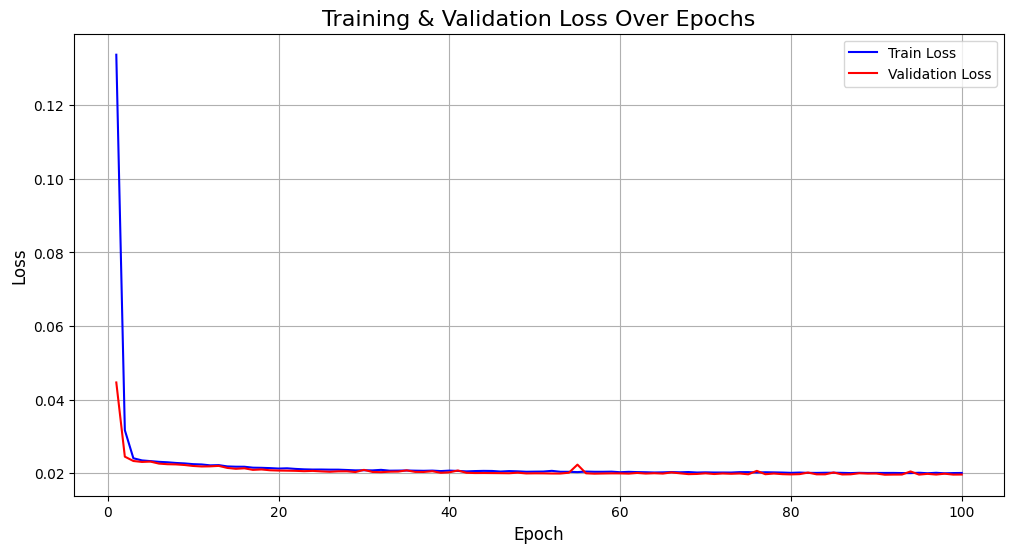

In [12]:
import matplotlib.pyplot as plt

# 그래프 크기 설정
plt.figure(figsize=(12, 6))

# 훈련 손실과 검증 손실 그래프 그리기
plt.plot(range(1, NUM_EPOCHS + 1), train_loss_history, label='Train Loss', color='blue')
plt.plot(range(1, NUM_EPOCHS + 1), val_loss_history, label='Validation Loss', color='red')

# 그래프 제목 및 축 레이블 설정
plt.title('Training & Validation Loss Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)

# 범례 표시
plt.legend()

# 그리드 표시
plt.grid(True)

# 그래프 보여주기
plt.show()

In [14]:
# 새로운 셀

import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# --- 설정 (★★★ 사용 전 꼭 수정해주세요 ★★★) ---
# 1. 평가에 사용할 테스트셋 폴더 경로
TEST_DIR = os.path.join(DATA_DIR, 'test')

# 2. 불러올 학습된 모델 가중치 파일의 경로
# 'trained_models' 폴더 안에 저장된 .pth 파일 중 가장 성능이 좋았던(best) 모델의 경로를 지정합니다.
MODEL_WEIGHTS_PATH = "pt/TBaodNet/best_model_epoch_91.pth" # XX 부분은 실제 파일 숫자로 변경
# --------------------------------------------------

# 모델 구조 로드 및 가중치 불러오기
evaluation_model = AODnet_MultiBranch().to(DEVICE)
evaluation_model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH, map_location=DEVICE))
evaluation_model.eval() # 모델을 반드시 평가 모드로 설정!

# 테스트 데이터 로더 준비
test_dataset = DehazeDataset(data_dir=TEST_DIR, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0) # num_workers=0으로 설정

# 점수를 저장할 리스트 초기화
psnr_scores = []
ssim_scores = []

print(f"\n===== '{MODEL_WEIGHTS_PATH}' 모델 성능 평가 시작 =====")

# 평가 루프
with torch.no_grad(): # 기울기 계산 비활성화
    for hazy_images, clean_images in tqdm(test_loader, desc="Evaluating"):
        hazy_images = hazy_images.to(DEVICE)
        
        # 모델 추론
        outputs = evaluation_model(hazy_images)
        
        # GPU 텐서를 CPU의 Numpy 배열로 변환 (skimage 계산용)
        # (B, C, H, W) -> (B, H, W, C) 형태로 변경 및 0-255 범위의 정수형으로 변환
        outputs_np = outputs.cpu().permute(0, 2, 3, 1).numpy() * 255
        clean_images_np = clean_images.cpu().permute(0, 2, 3, 1).numpy() * 255
        
        outputs_np = outputs_np.astype(np.uint8)
        clean_images_np = clean_images_np.astype(np.uint8)
        
        # 배치 내의 각 이미지에 대해 점수 계산
        for i in range(clean_images_np.shape[0]):
            gt_image = clean_images_np[i]
            pred_image = outputs_np[i]
            
            # PSNR 계산
            psnr = peak_signal_noise_ratio(gt_image, pred_image, data_range=255)
            psnr_scores.append(psnr)
            
            # SSIM 계산
            # channel_axis=-1 은 컬러 이미지(RGB)의 채널 축을 지정해줍니다.
            ssim = structural_similarity(gt_image, pred_image, channel_axis=-1, data_range=255)
            ssim_scores.append(ssim)

# 평균 점수 계산
avg_psnr = np.mean(psnr_scores)
avg_ssim = np.mean(ssim_scores)

print("\n===== 평가 완료 =====")
print(f"테스트 데이터셋 평균 PSNR: {avg_psnr:.4f} dB")
print(f"테스트 데이터셋 평균 SSIM: {avg_ssim:.4f}")

[Model] Multi-Branch AODNet 초기화 중...
[Model] Multi-Branch AODNet 초기화 완료


===== 'pt/TBaodNet/best_model_epoch_91.pth' 모델 성능 평가 시작 =====


Evaluating:   0%|          | 0/127 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 127/127 [00:32<00:00,  3.86it/s]


===== 평가 완료 =====
테스트 데이터셋 평균 PSNR: 18.6205 dB
테스트 데이터셋 평균 SSIM: 0.7409


[Model] Multi-Branch AODNet 초기화 중...
[Model] Multi-Branch AODNet 초기화 완료

이미지 복원을 시작합니다...
'dataset_split/test/input/51_rain.png' 복원 및 정답 이미지 로드 완료.
'dataset_split/test/input/im_0048_s95_a06.png' 복원 및 정답 이미지 로드 완료.
'dataset_split/test/input/NYU2_1331.jpg' 복원 및 정답 이미지 로드 완료.


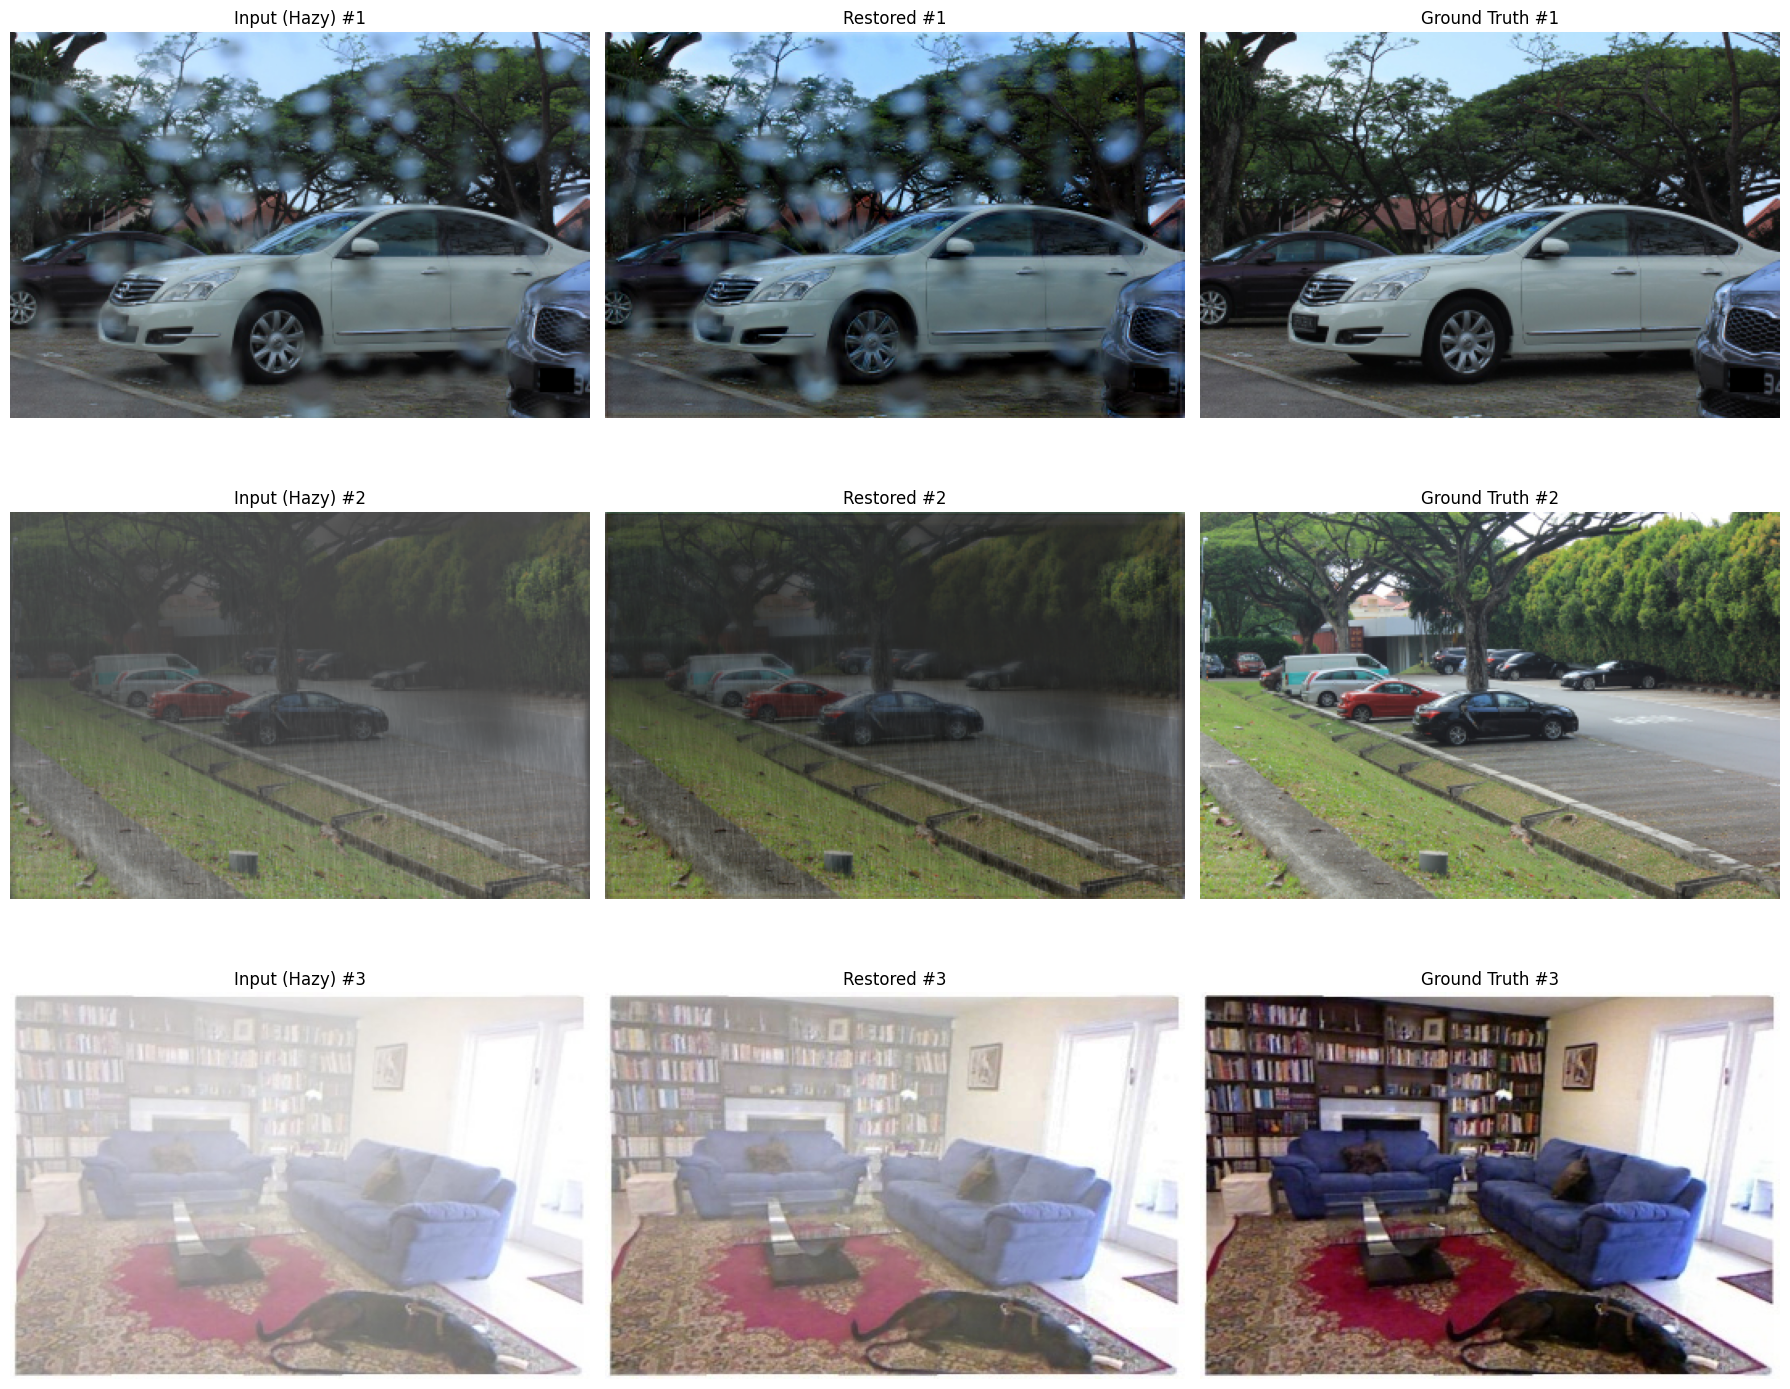


이미지 복원 및 비교 완료!


In [15]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
from torchvision import transforms
import os

# --- 설정 (★★★ 사용 전 꼭 수정해주세요 ★★★) ---
# 1. 불러올 학습된 모델 가중치 파일의 경로
MODEL_WEIGHTS_PATH = "pt/TBaodNet/best_model_epoch_91.pth"

# 2. 복원할 안개 이미지(input) 파일 경로들을 리스트 형태로 지정
HAZY_IMAGE_PATHS = [
    "dataset_split/test/input/51_rain.png",
    "dataset_split/test/input/im_0048_s95_a06.png",
    "dataset_split/test/input/NYU2_1331.jpg"
]

# 3. 정답 이미지(gt)가 들어있는 폴더 경로
GT_BASE_DIR = "dataset_split/test/gt"

# 4. 모델 학습 시 사용했던 이미지 해상도
TARGET_IMAGE_SIZE = (240, 360)
# ----------------------------------------------------------------------

# 모델 구조 로드 및 가중치 불러오기
evaluation_model = AODnet_MultiBranch().to(DEVICE) # DEVICE는 이전 셀에서 정의됨
evaluation_model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH, map_location=DEVICE))
evaluation_model.eval()

# 이미지 전처리 transform 정의
transform = transforms.Compose([
    transforms.Resize(TARGET_IMAGE_SIZE),
    transforms.ToTensor()
])

# 결과를 저장할 리스트 생성
hazy_images_pil = []
restored_images_pil = []
clean_images_pil = []

print("이미지 복원을 시작합니다...")

for hazy_path in HAZY_IMAGE_PATHS:
    try:
        filename = os.path.basename(hazy_path)
        
        # ★★★ 수정된 부분 ★★★
        # os.path.join으로 생성된 경로를 os.path.normpath로 정규화
        clean_path_raw = os.path.join(GT_BASE_DIR, filename)
        clean_path = os.path.normpath(clean_path_raw)
        
        if not os.path.exists(clean_path):
            print(f"경고: 짝이 되는 정답 이미지 '{clean_path}'를 찾을 수 없습니다. 건너뜁니다.")
            continue

        hazy_image = Image.open(hazy_path).convert('RGB')
        clean_image = Image.open(clean_path).convert('RGB')
        
        hazy_tensor = transform(hazy_image).unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            restored_tensor = evaluation_model(hazy_tensor)

        restored_image = transforms.ToPILImage()(restored_tensor.squeeze(0).cpu())

        hazy_images_pil.append(hazy_image)
        restored_images_pil.append(restored_image)
        clean_images_pil.append(clean_image)
        print(f"'{hazy_path}' 복원 및 정답 이미지 로드 완료.")

    except FileNotFoundError:
        print(f"오류: '{hazy_path}' 파일을 찾을 수 없습니다. 경로를 다시 확인해주세요.")
    except Exception as e:
        print(f"'{hazy_path}' 처리 중 오류 발생: {e}")

# --- 시각화 부분 ---
if hazy_images_pil:
    num_images = len(hazy_images_pil)
    # 3개의 행(이미지 쌍), 3개의 열(Input, Restored, GT)
    plt.figure(figsize=(18, 5 * num_images)) 

    for i in range(num_images):
        # --- i번째 이미지 쌍 ---
        
        # 1열: 입력(Hazy) 이미지
        plt.subplot(num_images, 3, i * 3 + 1)
        plt.imshow(hazy_images_pil[i])
        plt.title(f'Input (Hazy) #{i+1}')
        plt.axis('off')

        # 2열: 복원된 이미지
        plt.subplot(num_images, 3, i * 3 + 2)
        plt.imshow(restored_images_pil[i])
        plt.title(f'Restored #{i+1}')
        plt.axis('off')
        
        # 3열: 정답(GT) 이미지
        plt.subplot(num_images, 3, i * 3 + 3)
        plt.imshow(clean_images_pil[i])
        plt.title(f'Ground Truth #{i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    print("\n이미지 복원 및 비교 완료!")

In [13]:
# onnx 변환용 셀
# pth_to_onnx.py
import torch

# 1. 모델 구조 불러오기 및 가중치 로드
model = AODnet_MultiBranch()
model.load_state_dict(torch.load('./pt/TBaodNet/best_model_epoch_91.pth', map_location='cpu'))
model.eval() # 반드시 evaluation 모드로 설정!

# 2. 모델에 입력될 더미 데이터 생성 (중요!)
# 모델이 학습할 때 사용한 이미지 크기와 동일하게 맞춰주세요.
# 예: (배치크기, 채널, 높이, 너비)
dummy_input = torch.randn(1, 3, 360, 240) 

# 3. ONNX 파일로 변환
onnx_file_path = "aodnet.onnx"
torch.onnx.export(model,
                  dummy_input,
                  onnx_file_path,
                  export_params=True,
                  opset_version=11, # 호환성을 위해 버전을 명시하는 것이 좋음
                  do_constant_folding=True,
                  input_names = ['input'],
                  output_names = ['output'])

print(f"모델이 {onnx_file_path} 파일로 성공적으로 변환되었습니다.")

[Model] Multi-Branch AODNet 초기화 중...
[Model] Multi-Branch AODNet 초기화 완료

모델이 aodnet.onnx 파일로 성공적으로 변환되었습니다.


In [5]:
# onnx_to_tflite.py
#

import tensorflow as tf
from onnx_tf.backend import prepare
import onnx

# 1. ONNX 모델 로드
onnx_model = onnx.load("aodnet.onnx")
tf_rep = prepare(onnx_model)

# 2. TensorFlow SavedModel 형식으로 임시 저장
save_path = "C:/temp/aodnet_tf_model"
tf_rep.export_graph(save_path)

# 3. TensorFlow Lite 변환기 생성
# converter = tf.lite.TFLiteConverter.from_saved_model("aodnet_tf_model") # 기존 코드
converter = tf.lite.TFLiteConverter.from_saved_model(save_path) # 변경된 코드

# 4. (강력 추천) 8비트 정수형으로 양자화하여 최적화
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# 양자화를 위해 대표 데이터셋(representative dataset) 제공이 필요할 수 있습니다.
# 이는 모델이 실제 처리할 데이터의 분포를 알려주는 역할을 합니다.
# 예: 실제 안개 낀 이미지 100장을 전처리하여 사용
# def representative_data_gen():
#   for image in representative_dataset:
#     # 이미지를 모델 입력에 맞게 전처리 (리사이즈, 정규화 등)
#     processed_image = preprocess(image) 
#     yield [processed_image]
# converter.representative_dataset = representative_data_gen
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]


# 5. TensorFlow Lite 모델로 변환
tflite_model = converter.convert()

# 6. .tflite 파일로 저장
with open("aodnet_model.tflite", "wb") as f:
    f.write(tflite_model)

print("TensorFlow Lite 모델(aodnet_model.tflite) 변환 및 저장 완료!")

INFO:tensorflow:Assets written to: C:/temp/aodnet_tf_model\assets


INFO:tensorflow:Assets written to: C:/temp/aodnet_tf_model\assets


TensorFlow Lite 모델(aodnet_model.tflite) 변환 및 저장 완료!


In [ ]:
#!/usr/bin/python3
import cv2
import numpy as np
import time
from picamera2 import Picamera2
from tflite_runtime.interpreter import Interpreter

# --- 설정 ---
MODEL_PATH = 'TBaodnet_model.tflite'
WIDTH, HEIGHT = 360, 240

def main():
    # --- 1. TFLite 모델 로드 및 초기화 ---
    try:
        interpreter = Interpreter(model_path=MODEL_PATH)
        interpreter.allocate_tensors()
        
        input_details = interpreter.get_input_details()
        output_details = interpreter.get_output_details()
        
        model_input_shape = input_details[0]['shape']
        print(f"모델이 요구하는 실제 입력 형태: {model_input_shape}")

    except Exception as e:
        print(f"모델 로딩에 실패했습니다: {e}")
        return

    # --- 2. PiCamera2 설정 및 시작 ---
    picam2 = Picamera2()
    
    config = picam2.create_preview_configuration(
        main={"size": (WIDTH, HEIGHT), "format": "RGB888"}
    )
    picam2.configure(config)
    picam2.start()
    time.sleep(1)
    print("카메라가 시작되었습니다.")


    # --- 3. 실시간 영상 처리 루프 ---
    fps_counter = 0
    start_time = time.time()

    try:
        while True:
            # 원본 프레임을 받아옵니다.
            frame_original = picam2.capture_array()

            # ★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★
            # ★ 여기가 핵심! OpenCV를 사용해 프레임을 180도 회전시킵니다 ★
            # ★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★
            frame = cv2.rotate(frame_original, cv2.ROTATE_180)

            # 모델 입력에 맞게 프레임 전처리
            _, _, model_height, model_width = model_input_shape 
            input_image = cv2.resize(frame, (model_width, model_height))
            
            input_data_nhwc = np.expand_dims(input_image, axis=0)
            input_data_nhwc = (input_data_nhwc.astype(np.float32) / 255.0)

            input_data = np.transpose(input_data_nhwc, (0, 3, 1, 2))

            # 모델 추론 실행
            interpreter.set_tensor(input_details[0]['index'], input_data)
            interpreter.invoke()
            output_data = interpreter.get_tensor(output_details[0]['index'])

            # 추론 결과 후처리
            output_data_nhwc = np.transpose(output_data, (0, 2, 3, 1))
            processed_image = (output_data_nhwc[0] * 255.0).astype(np.uint8)
            
            # 처리된 영상만 화면에 표시
            processed_bgr = cv2.cvtColor(processed_image, cv2.COLOR_RGB2BGR)
            cv2.imshow('Processed by TFLite', processed_bgr)

            # FPS 계산
            fps_counter += 1
            if time.time() - start_time >= 1:
                print(f"FPS: {fps_counter}")
                fps_counter = 0
                start_time = time.time()
            
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    
    finally:
        # --- 4. 종료 처리 ---
        print("프로그램을 종료합니다.")
        picam2.stop()
        cv2.destroyAllWindows()


if __name__ == '__main__':
    main()